We will use a shapefile  of water areas in Austin, Texas, extracted from [OpenStreetMap](openstreetmap.org) by [Mapzen](https://mapzen.com/data/metro-extracts).

In [1]:
from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt
import fiona
%matplotlib inline

data_dir = os.path.join(os.path.abspath('..'), 'data')
input_file = os.path.join(data_dir, 'austin-osm', 'austin_texas_osm_waterareas.shp')
if os.path.exists(input_file):
    print('Input file:', input_file)
else:
    print('Please download the tutorial data or fix the path!')

Input file: /Users/kjordahl/scipy2015/geospatial_tutorial/data/austin-osm/austin_texas_osm_waterareas.shp


Reading a GIS vector file begins by opening it in mode `'r'` using Fiona’s `open()` function. It returns an open `Collection` object.

In [2]:
c = fiona.open(input_file, 'r')
c

<open Collection '/Users/kjordahl/scipy2015/geospatial_tutorial/data/austin-osm/austin_texas_osm_waterareas.shp:austin_texas_osm_waterareas', mode 'r' at 0x104136bd0>

In [3]:
len(c)

867

A `Collection` has a read-only driver attribute which names the OGR format driver used to open the vector file.

In [4]:
c.driver

u'ESRI Shapefile'

The coordinate reference system (CRS) of the collection’s vector data is accessed via a read-only crs attribute, represented by a mapping of PROJ.4 parameters.

In [5]:
c.crs

{'init': u'epsg:4326'}

The fiona.crs module provides 3 functions to assist with these mappings.

In [6]:
from fiona.crs import to_string, from_string, from_epsg

`to_string()` converts mappings to PROJ.4 strings:

In [7]:
print(to_string(c.crs))

+init=epsg:4326


`from_string()` does the inverse.

In [8]:
from_string("+datum=WGS84 +ellps=WGS84 +no_defs +proj=longlat")

{'datum': 'WGS84', 'ellps': 'WGS84', 'no_defs': True, 'proj': 'longlat'}

`from_epsg()` is a shortcut to CRS mappings from EPSG codes.

In [9]:
from_epsg(3857)

{'init': 'epsg:3857', 'no_defs': True}

Fiona’s `Collection` acts much like an open Python file, but is iterable on records rather than lines.

In [10]:
rec = c.next()

A record you get from a collection is a Python dict structured exactly like a GeoJSON Feature. Fiona records are self-describing; the names of its fields are contained within the data structure and the values in the fields are typed properly for the type of record. Numeric field values are instances of type int and float, for example, not strings.

In [11]:
rec.keys()

['geometry', 'type', 'id', 'properties']

A record has a `properties` key. Its corresponding value is a mapping. The keys of the properties mapping are the same as the keys of the properties mapping in the schema of its collection.

In [12]:
rec['properties']

OrderedDict([(u'id', 1.0), (u'osm_id', -2439371.0), (u'name', u'Soil Conservation Service Site 14 Reservoir'), (u'type', u'water'), (u'area', 3.02358e-05)])

A record has a geometry key. Its corresponding value is a mapping with type and coordinates keys. Since the coordinates are just tuples, or lists of tuples, or lists of lists of tuples, the type tells you how to interpret them.

In [13]:
rec['geometry'].keys()

['type', 'coordinates']

In [14]:
rec['geometry']['type']

'Polygon'

(110, 2)
(11, 2)


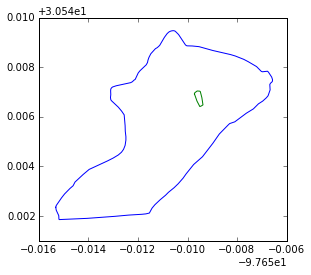

In [15]:
for poly in rec['geometry']['coordinates']:
    coords = np.array(poly).squeeze()
    print(coords.shape)
    plt.plot(coords[:,0], coords[:,1])
plt.gca().set_aspect('equal')

Next, we'll extract the outer polygon that defines the shoreline of Lake Travis.

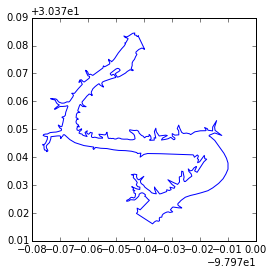

In [16]:
lake_travis = [rec for rec in c if rec['properties']['name'] == 'Lake Travis']
outer = lake_travis[0]['geometry']['coordinates']
coords = np.array(outer[0][0]).squeeze()
plt.plot(coords[:,0], coords[:,1], fillstyle='full')
plt.gca().set_aspect('equal')

We didn't open the file inside a context manager (`with` statement), which would have been good practice, so we need to close the file explicitly.

In [17]:
c.close()

### Filtering

With some vector data formats a spatial index accompanies the data file, allowing efficient bounding box searches. A collection’s `filter()` method returns an iterator over records that intersect a given `(minx, miny, maxx, maxy)` bounding box. The collection’s own coordinate reference system (in this case WGS84 longitude/latitude) is used to interpret the box’s values.

(This time we'll use a context manager so the file is closed automatically.)

In [18]:
with fiona.open(input_file, 'r') as c:
    hits = c.filter(bbox=(-98.210438, 30.357799, -97.884216, 30.568691))
    print(len(list(hits)))

19
